<a href="https://colab.research.google.com/github/RawanKhaled20/YawningDetection/blob/main/Yawning_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rawankhaled20","key":"f5a17aecb67ca4675b425dadbe4ab60e"}'}

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d gauravduttakiit/detectyawning

 79% 30.0M/38.0M [00:00<00:00, 134MB/s] 
100% 38.0M/38.0M [00:00<00:00, 69.7MB/s]


In [ ]:
! unzip detectyawning.zip

In [ ]:
!pip install scikit-plot

import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
df = pd.read_csv('/content/train.csv')
print(df.shape)
df.head()

(5242, 2)


,image_id,label
0,train\123456 (3565).jpg,1
1,train\1234567 (2741).jpg,0
2,train\123456 (2705).jpg,1
3,train\123456 (1319).jpg,1
4,train\1234567 (2215).jpg,0


In [ ]:
df.label.unique()

array([1, 0])

In [ ]:
emotion_label_to_text = {0:'Yawn', 1:'No_yawn'}

In [ ]:
df.label.value_counts()

0    2692
1    2550
Name: label, dtype: int64

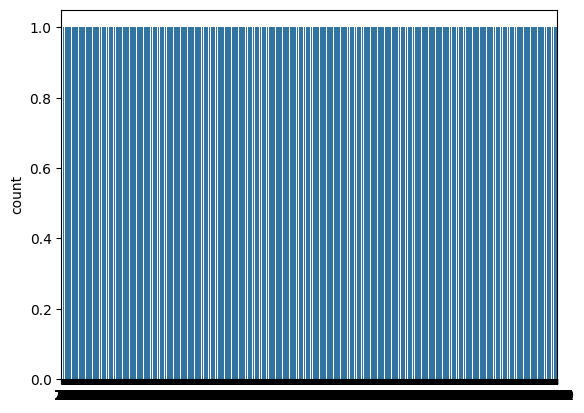

In [ ]:
sns.countplot(df.label)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [ ]:
math.sqrt(len(df.image_id[0].split(' ')))

1.4142135623730951

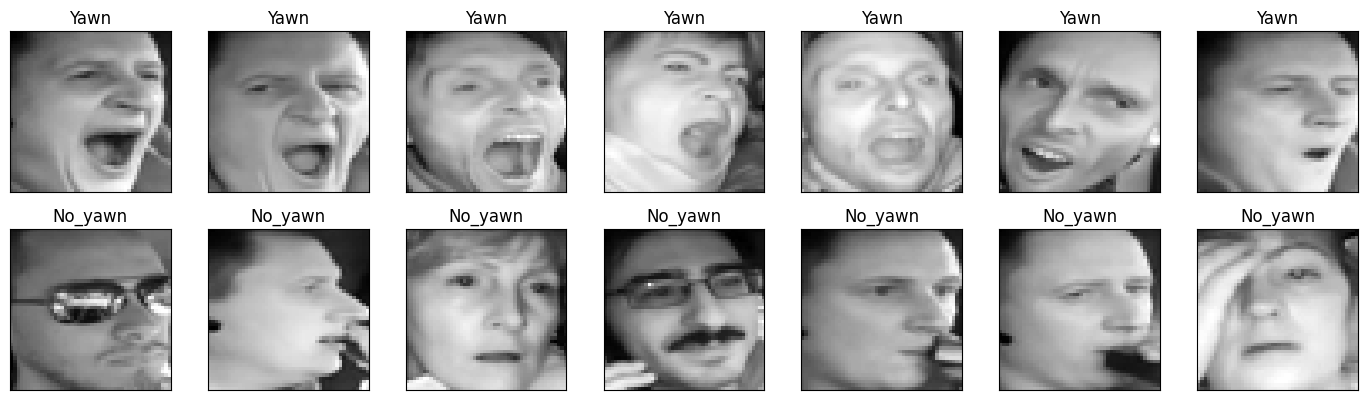

In [ ]:
from PIL import Image
import os

fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.label.unique()):
    for j in range(7):
        image_number = df[df.label == label].image_id.iloc[k]

        # Remove 'train\' and '.jpg' from image number
        image_number = image_number.replace('train\\', '').replace('.jpg', '')

        image_path = os.path.join("/content/train", str(label), str(image_number) + ".jpg")

        # Load image using PIL (Python Imaging Library)
        try:
            img = Image.open(image_path)
        except FileNotFoundError:
            print("Image not found:", image_path)
            continue

        # Resize image to (48, 48)
        img = img.resize((48, 48))

        # Convert image to grayscale
        img = img.convert('L')

        # Convert image to numpy array
        px = np.array(img).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()



In [ ]:
INTERESTED_LABELS = [0,1]

In [ ]:
df = df[df.label.isin(INTERESTED_LABELS)]
df.shape

(5242, 2)

`Now I will make the data compatible for neural networks.`

In [ ]:
from PIL import Image
import os

# Define an empty list to store the images
img_list = []

# Iterate over unique labels
for label in sorted(df.label.unique()):
    # Iterate for a fixed range (7 in this case)
    for j in range(7):
        # Get the image number for the current label
        image_number = df[df.label == label].image_id.iloc[k]

        # Remove 'train\' and '.jpg' from image number to construct the image path
        image_number = image_number.replace('train\\', '').replace('.jpg', '')

        # Construct the image path
        image_path = os.path.join("/content/train", str(label), str(image_number) + ".jpg")

        # Open and preprocess the image
        img = Image.open(image_path).convert('L').resize((48, 48))

        # Convert the image to numpy array and append it to img_list
        img_array = np.array(img).astype('float32').reshape(48, 48, 1)
        img_list.append(img_array)

# Convert the list of images to a numpy array
img_array = np.stack(img_list, axis=0)



In [ ]:
img_array.shape

(14, 48, 48, 1)

In [ ]:
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
img_labels = le.fit_transform(df.label)
img_labels = to_categorical(img_labels)
img_labels.shape

(5242, 2)

In [ ]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1}


`Splitting the data into training and validation set.`

In [ ]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train and validation sets
X_train_df, X_valid_df, y_train_df, y_valid_df = train_test_split(df['image_id'], df['label'],
                                                                  shuffle=True, stratify=df['label'],
                                                                  test_size=0.1, random_state=42)

# Load and preprocess images for training set
X_train = []
for image_id, label in zip(X_train_df, y_train_df):
    image_path = os.path.join("/content/train", str(label), str(image_id).replace('train\\', '') )
    img = Image.open(image_path).convert('L').resize((48, 48))
    img_array = np.array(img).astype('float32').reshape(48, 48, 1)
    X_train.append(img_array)
X_train = np.array(X_train)

# Load and preprocess images for validation set
X_valid = []
for image_id, label in zip(X_valid_df, y_valid_df):
    image_path = os.path.join("/content/train", str(label), str(image_id).replace('train\\', '') )
    img = Image.open(image_path).convert('L').resize((48, 48))
    img_array = np.array(img).astype('float32').reshape(48, 48, 1)
    X_valid.append(img_array)
X_valid = np.array(X_valid)

# Now you have X_train and X_valid as arrays of images


In [ ]:
del df
del img_array
del img_labels

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]

In [ ]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_valid.reshape(X_valid.shape[0], -1)

# Initialize the logistic regression model
logistic_model = LogisticRegression(max_iter=500)

# Train the model
logistic_model.fit(X_train_flat, y_train_df)

# Make predictions
y_pred = LogisticRegression.predict(X_test_flat)

# Calculate accuracy
accuracy = accuracy_score(y_valid_df, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8895238095238095


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_valid.reshape(X_valid.shape[0], -1)

# Initialize the RandomForestClassifier model
rf_model = RandomForestClassifier()

# Train the model
rf_model.fit(X_train_flat, y_train_df)

# Make predictions
y_pred = rf_model.predict(X_test_flat)

# Calculate accuracy
accuracy = accuracy_score(y_valid_df, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9352380952380952


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_valid.reshape(X_valid.shape[0], -1)

# Initialize the SVM model
svm_model = SVC()

# Train the model
svm_model.fit(X_train_flat, y_train_df)

# Make predictions
y_pred = svm_model.predict(X_test_flat)

# Calculate accuracy
accuracy = accuracy_score(y_valid_df, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9314285714285714


In [ ]:
import cv2
import numpy as np

# Load and preprocess the image
image_path = "/content/Yawning-1024x731.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image in grayscale
resized_image = cv2.resize(image, (48, 48))  # Resize the image to match the model input size
flattened_image = resized_image.flatten().reshape(1, -1)  # Flatten and reshape the image

# Make prediction using the logistic regression model
predicted_class = logistic_model.predict(flattened_image)
# Make prediction using the randomforest regression model
predicted_class_rf = rf_model.predict(flattened_image)
# Make prediction using the svm model
predicted_class_svm = svm_model.predict(flattened_image)

# Print the predicted class
print("Predicted Class:", predicted_class)
print("Predicted Class:", predicted_class_rf)
print("Predicted Class:", predicted_class_svm)

Predicted Class: [1]
Predicted Class: [1]
Predicted Class: [1]


In [ ]:
import pickle

# Save the model to a file
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(logistic_model, f)

In [ ]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            1,
            activation='sigmoid',
            name='out_layer'
        )
    )

    net.compile(
        loss='binary_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [ ]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [ ]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [ ]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])
history = model.fit_generator(
    train_datagen.flow(X_train, y_train_df, batch_size=batch_size),
    validation_data=(X_valid, y_valid_df),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

<ipython-input-28-7e66bea8c081>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
147/147 [==============================] - 32s 76ms/step - loss: 0.7819 - accuracy: 0.6305 - val_loss: 0.6361 - val_accuracy: 0.7314 - lr: 0.0010
Epoch 2/100
147/147 [==============================] - 5s 37ms/step - loss: 0.5566 - accuracy: 0.7428 - val_loss: 0.2998 - val_accuracy: 0.8914 - lr: 0.0010
Epoch 3/100
147/147 [==============================] - 8s 54ms/step - loss: 0.4341 - accuracy: 0.8098 - val_loss: 0.2449 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 4/100
147/147 [==============================] - 9s 58ms/step - loss: 0.3453 - accuracy: 0.8512 - val_loss: 0.1827 - val_accuracy: 0.9238 - lr: 0.0010
Epoch 5/100
147/147 [==============================] - 10s 68ms/step - loss: 0.3186 - accuracy: 0.8703 - val_loss: 0.1724 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 6/100
147/147 [==============================] - 7s 45ms/step - loss: 0.3000 - accuracy: 0.8815 - val_loss: 0.1211 - val_accuracy: 0.9448 - lr: 0.0010
Epoch 7/100
147/147 [==============================] - 6

In [ ]:
model.save("mode5.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

In [ ]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [ ]:
mapper = {
    0: "Yawn",
    1: "No Yawn",
}

1/1 [==============================] - 0s 91ms/step


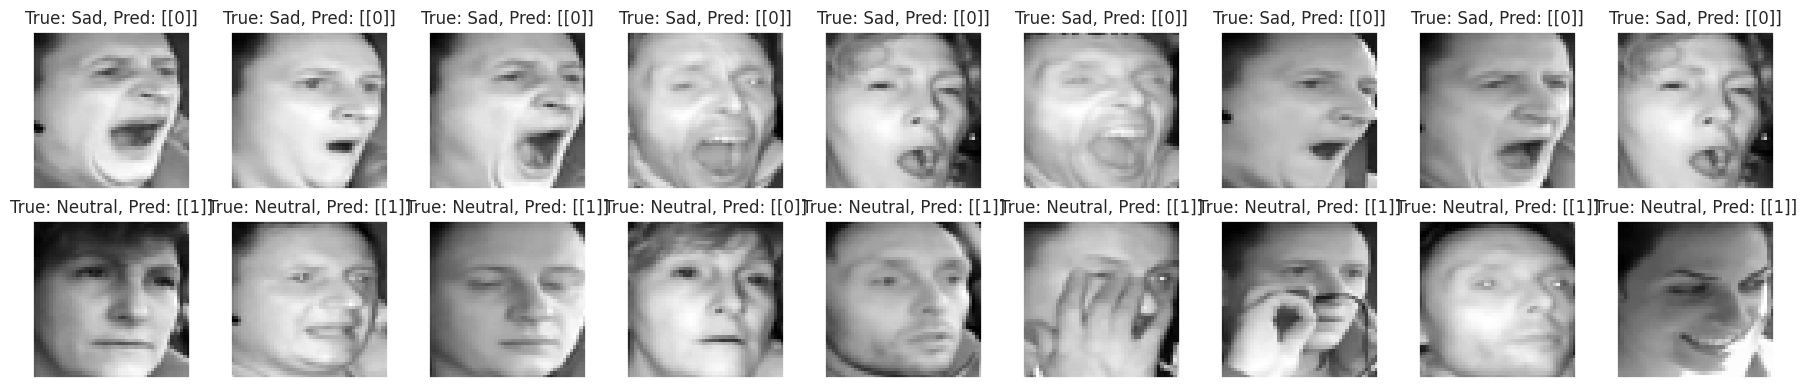

In [ ]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid_df == 0)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid_df == 1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = pyplot.subplot(2, 9, i+1)
    sample_img_sad = X_valid[sadidx, :, :, 0]  # Assuming X_valid contains the images as arrays
    ax.imshow(sample_img_sad, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Make prediction for sad image
    prediction_sad = model.predict(sample_img_sad.reshape(1, 48, 48, 1))
    predicted_class_sad = (prediction_sad > 0.5).astype("int32")  # Use threshold 0.5 for binary classification
    ax.set_title(f"True: Sad, Pred: {predicted_class_sad}")

    ax = pyplot.subplot(2, 9, i+10)
    sample_img_neutral = X_valid[neuidx, :, :, 0]  # Assuming X_valid contains the images as arrays
    ax.imshow(sample_img_neutral, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    # Make prediction for neutral image
    prediction_neutral = model.predict(sample_img_neutral.reshape(1, 48, 48, 1))
    predicted_class_neutral = (prediction_neutral > 0.5).astype("int32")  # Use threshold 0.5 for binary classification
    ax.set_title(f"True: Neutral, Pred: {predicted_class_neutral}")

pyplot.tight_layout()


1/1 [==============================] - 0s 28ms/step


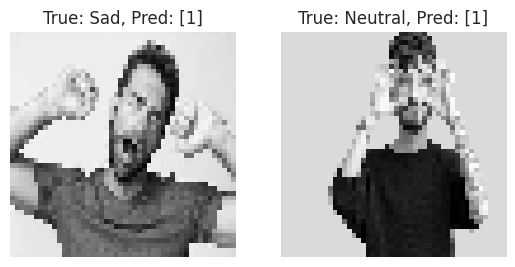

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load input images (adjust paths accordingly)
sad_image_path = "/content/yawn.jpeg"
neutral_image_path = "/content/awake.jpeg"

# Load and preprocess sad image
sad_image = cv2.imread(sad_image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
sad_image = cv2.resize(sad_image, (48, 48))  # Resize to model input size
sad_image = sad_image.astype('float32') / 255.0  # Normalize
sad_image = np.expand_dims(sad_image, axis=-1)  # Add channel dimension
sad_image = np.expand_dims(sad_image, axis=0)  # Add batch dimension

# Load and preprocess neutral image
neutral_image = cv2.imread(neutral_image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
neutral_image = cv2.resize(neutral_image, (48, 48))  # Resize to model input size
neutral_image = neutral_image.astype('float32') / 255.0  # Normalize
neutral_image = np.expand_dims(neutral_image, axis=-1)  # Add channel dimension
neutral_image = np.expand_dims(neutral_image, axis=0)  # Add batch dimension

# Make predictions for sad image
prediction_sad = model.predict(sad_image)
predicted_class_sad = (prediction_sad > 0.5).astype("int32")  # Use threshold 0.5 for binary classification

# Make predictions for neutral image
prediction_neutral = model.predict(neutral_image)
predicted_class_neutral = (prediction_neutral > 0.5).astype("int32")  # Use threshold 0.5 for binary classification

# Visualize sad image and prediction
plt.subplot(1, 2, 1)
plt.imshow(sad_image[0, :, :, 0], cmap='gray')
plt.title(f"True: Sad, Pred: {predicted_class_sad[0]}")
plt.axis('off')

# Visualize neutral image and prediction
plt.subplot(1, 2, 2)
plt.imshow(neutral_image[0, :, :, 0], cmap='gray')
plt.title(f"True: Neutral, Pred: {predicted_class_neutral[0]}")
plt.axis('off')

plt.show()

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.